# PROJECT 1 - PART 2

## 0 - imports

In [119]:
from pathlib import Path
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
from tabulate import tabulate
from captum.attr import IntegratedGradients
import torch
import random

## 1 - Q1 Exploratory Data Analysis

### 1.1 - loading data

In [66]:
# 0 - path to train/test/val folders
train = Path("datasets/chest_xray/train")
val = Path("datasets/chest_xray/val")
test = Path("datasets/chest_xray/test")

# 1 - function to create dataframe for train, val, test data
def create_dataframe(directory):
    # path to the normal and pneumonia sub-directories
    normal_cases_dir = directory / 'NORMAL'
    pneumonia_cases_dir = directory / 'PNEUMONIA'

    # list of all the images
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

    data = []

    # set label for normal cases to be 0
    for img in normal_cases:
        data.append((img, 0))

    # set label for pneumonia cases to be 1
    for img in pneumonia_cases:
        data.append((img, 1))

    # shuffle otherwise all 0 and then all 1
    df = pd.DataFrame(data, columns=['image', 'label'])
    df = df.sample(frac=1.).reset_index(drop=True)
    
    return df


train_df = create_dataframe(train)
val_df = create_dataframe(val)
test_df = create_dataframe(test)

print("Train Data:")
print(train_df.head())

print("\nVal Data:")
print(val_df.head())

print("\nTest Data:")
print(test_df.head())

Train Data:
                                               image  label
0  datasets/chest_xray/train/PNEUMONIA/person406_...      1
1  datasets/chest_xray/train/PNEUMONIA/person501_...      1
2  datasets/chest_xray/train/PNEUMONIA/person1534...      1
3  datasets/chest_xray/train/PNEUMONIA/person124_...      1
4  datasets/chest_xray/train/PNEUMONIA/person1168...      1

Val Data:
                                               image  label
0  datasets/chest_xray/val/PNEUMONIA/person1954_b...      1
1  datasets/chest_xray/val/NORMAL/NORMAL2-IM-1430...      0
2  datasets/chest_xray/val/PNEUMONIA/person1952_b...      1
3  datasets/chest_xray/val/PNEUMONIA/person1950_b...      1
4  datasets/chest_xray/val/NORMAL/NORMAL2-IM-1431...      0

Test Data:
                                               image  label
0  datasets/chest_xray/test/PNEUMONIA/person152_b...      1
1  datasets/chest_xray/test/PNEUMONIA/person101_b...      1
2  datasets/chest_xray/test/PNEUMONIA/person53_vi...      1
3  da

In [74]:
# X and y splits
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

### 1.2 - dataset exploration

In [113]:
# 0 - explore dataset dimension
def get_dataset_info(directory):
    pneumonia_path = os.path.join(directory, 'PNEUMONIA')
    normal_path = os.path.join(directory, 'NORMAL')
    num_pneumonia = len(os.listdir(pneumonia_path))
    num_normal = len(os.listdir(normal_path))
    return num_pneumonia, num_normal

train_pneumonia, train_normal = get_dataset_info(train)
val_pneumonia, val_normal = get_dataset_info(val)
test_pneumonia, test_normal = get_dataset_info(test)

data = [
    ["Train set", train_pneumonia, train_normal],
    ["Validation set", val_pneumonia, val_normal],
    ["Test set", test_pneumonia, test_normal]
]

headers = ["Dataset", "PNEUMONIA", "NORMAL"]

print(tabulate(data, headers=headers, tablefmt="grid"))


+----------------+-------------+----------+
| Dataset        |   PNEUMONIA |   NORMAL |
+================+=============+==========+
| Train set      |        3875 |     1341 |
+----------------+-------------+----------+
| Validation set |           8 |        8 |
+----------------+-------------+----------+
| Test set       |         390 |      234 |
+----------------+-------------+----------+


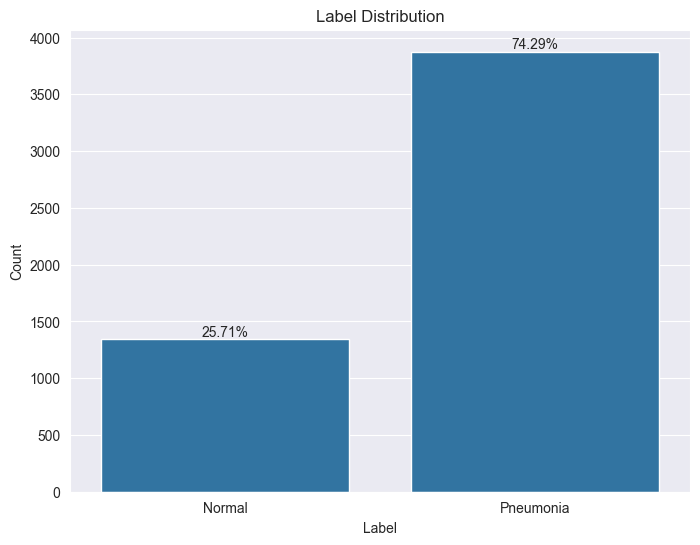

In [115]:
# 1 - label distribution
label_counts = train_df['label'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
ax=sb.countplot(x='label', data=train_df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Normal', 'Pneumonia'])
for i,p in enumerate(ax.patches):
        height = p.get_height()
        if height > 0: 
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 30,f'{label_counts[i]:.2f}%',
                    ha="center")
plt.show()

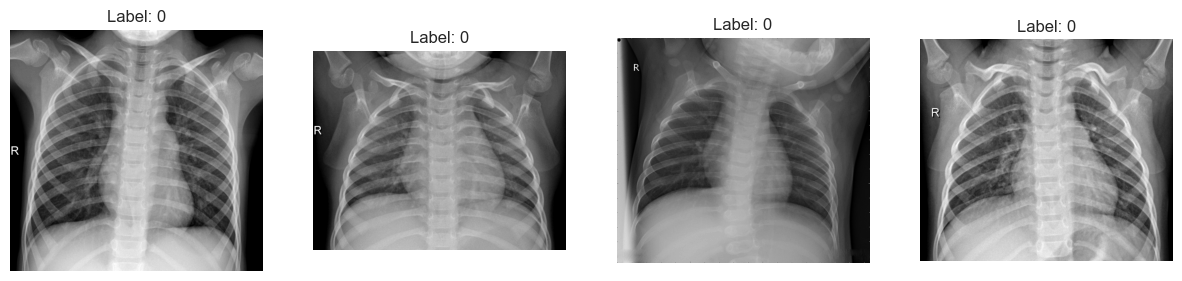

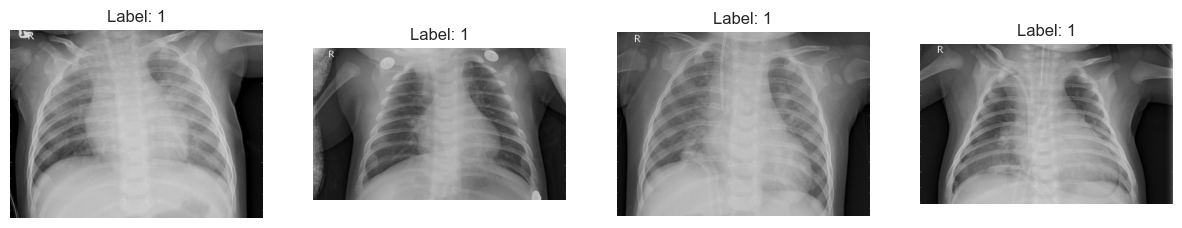

In [116]:
# 3 - plot samples
def plot_examples(df, label, num_examples=4):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    filtered_df = df[df['label'] == label].sample(num_examples)
    for i, (_, row) in enumerate(filtered_df.iterrows()):
        img_path = row['image']
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

plot_examples(train_df, label=0)
plot_examples(train_df, label=1)

#### REPORT:
- I can't see any difference between normal and pneumonia xrays
- data is highly imbalanced. We have almost with thrice pneumonia cases here as compared to the normal cases. To increase the number of training examples, we can use data augmentation


### 1.3 - data preprocessing

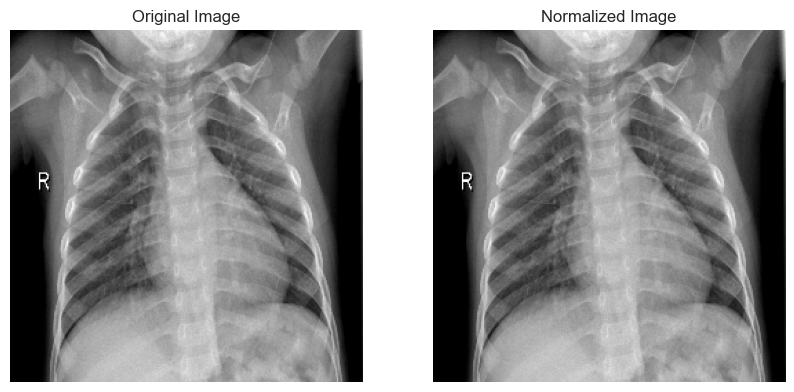

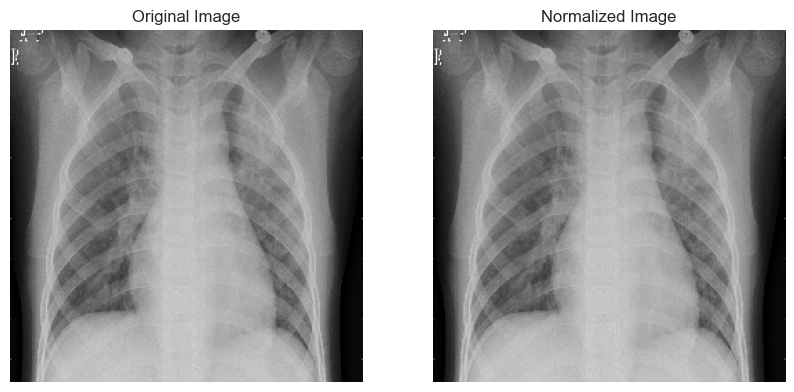

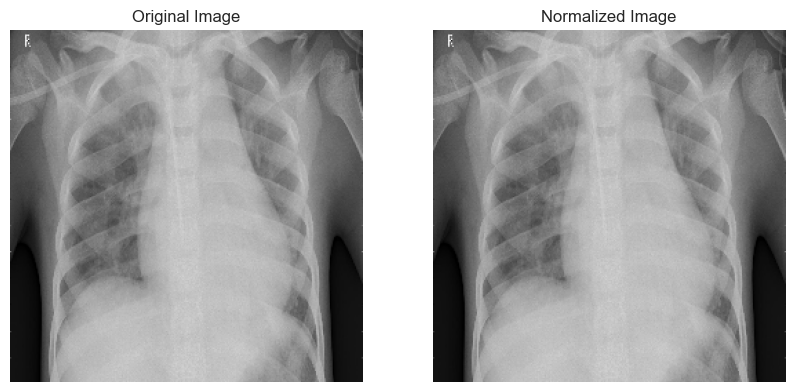

In [103]:
# 0 - greyscale normalization (needed??)
def read_and_normalize_image(image_path, target_size=(256, 256)):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized / 255.0
    return img_resized, img_normalized

# work in batches of data
def image_generator(dataframe, batch_size=32):
    num_samples = len(dataframe)
    while True:
        dataframe = shuffle(dataframe)
        for offset in range(0, num_samples, batch_size):
            batch_df = dataframe[offset:offset+batch_size]
            images = []
            normalized_images = []
            labels = []
            for _, row in batch_df.iterrows():
                img_path = row['image']
                img_resized, img_normalized = read_and_normalize_image(img_path)
                images.append(img_resized)
                normalized_images.append(img_normalized)
            yield np.array(images), np.array(normalized_images), np.array(labels)

# Define batch size
batch_size = 32 

train_generator = image_generator(X_train, batch_size=batch_size)
val_generator = image_generator(X_val, batch_size=batch_size)
test_generator = image_generator(X_test, batch_size=batch_size)

# look at the difference
for i in range(1):
    X_batch, X_normalized_batch, y_batch = next(train_generator)
    for j in range(3):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(X_batch[j], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(X_normalized_batch[j], cmap='gray')
        plt.title('Normalized Image')
        plt.axis('off')
        plt.show()


## 2 - Q2 CNN Classifier

## 3 - Q3 Integrated Gradients

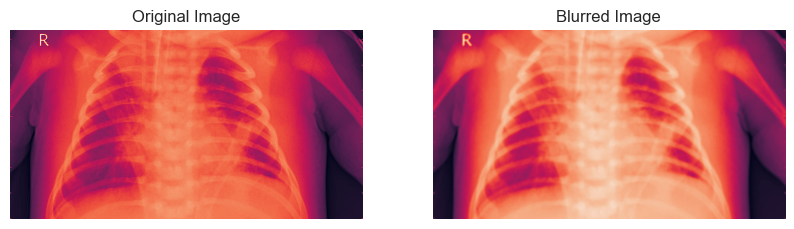

In [158]:
# create baseline
baseline_img = random.choice(test_df['image'])
baseline_img = Image.open(baseline_img)
def create_blurred_baseline(image, blur_radius):
    image_np = np.array(image)
    blurred_image = cv2.GaussianBlur(image_np, (blur_radius, blur_radius), 0)
    return blurred_image
blur_radius = 11
blurred_baseline = create_blurred_baseline(baseline_img, blur_radius)

# original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(baseline_img)
plt.title('Original Image')
plt.axis('off')
# blurred image
plt.subplot(1, 2, 2)
plt.imshow(blurred_baseline)
plt.title('Blurred Image')
plt.axis('off')
plt.show()

# to tensor
baseline_img_tensor = torch.tensor(blurred_baseline, dtype=torch.float32)
# alternatively: baseline_img_tensor = torch.tensor([0.0])


In [106]:
# 0 - integrated gradients method and attributions values
ig = IntegratedGradients(model)
attributions = ig.attribute(X_test, baselines=baseline_img_tensor)

/Users/neo/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got DataFrame"

In [ ]:
# 1 - attribution maps
test_df_label_0 = test_df[test_df['label'] == 0].head(5)['image'].tolist()
test_df_label_1 = test_df[test_df['label'] == 1].head(5)['image'].tolist()

def visualize_attributions(images, title):
    for img in images:
        attributions = ig.attribute(img, baseline_img_tensor)

        # image
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original Image')

        #attribution map
        plt.subplot(1, 2, 2)
        plt.imshow(attributions.squeeze().cpu().detach().numpy(), cmap='viridis', alpha=0.8)
        plt.title('Attribution Map')

        plt.suptitle(title)
        plt.show()

# Visualize attribution maps for healthy and pneunoma images
visualize_attributions(test_df_label_0, title='Healthy')
visualize_attributions(test_df_label_1, title='Pneunoma')

## 4 - Q4 GRAD-CAM

## 5 - Q5 DATA RANDOMIZATION TEST

In [ ]:
#TODO
# random permutation of labels
permuted_train_df = train_df.copy()
permuted_train_df['label'] = np.random.permutation(permuted_train_df['label'])

# train again model


# compute attributions for the permuted model on the test set

# compare atrtibutions of original and permuted models
mean_abs_diff = torch.mean(torch.abs(original_attributions - permuted_attributions))
print(f'Mean Absolute Difference: {mean_abs_diff:.4f}')